<h2 align="center">Vehicle Damage Detection Project</h2>

In [2]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load Data

In [4]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.01, saturation=0.01),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
dataset_path = '/content/drive/MyDrive/content/dataset'

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [7]:
classes_names = dataset.classes
classes_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [8]:
num_classes = len(classes_names)
num_classes

6

In [9]:
train_size = int(len(dataset)*0.75)
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [10]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [12]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [13]:
labels[0]

tensor(5)

In [14]:
images[0].shape

torch.Size([3, 224, 224])

In [15]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

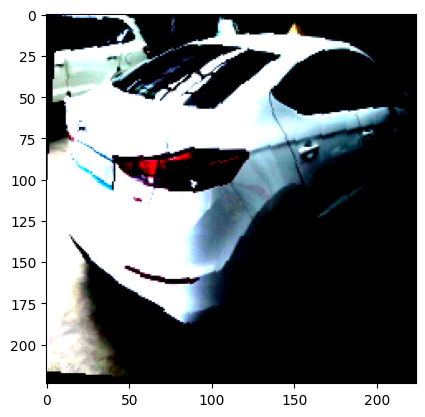

In [16]:
plt.imshow(images[0].permute(1,2,0))
plt.show()





### Model 1: CNN

In [17]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),   #(16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),   # (16, 112, 112)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),   # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [18]:
images.size(0)

32

In [19]:
len(train_loader.dataset)

1725

In [50]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0

        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

         # Validation
        model.eval()
        correct=0
        total=0
        all_predicted= []
        all_labels = []

        with torch.no_grad():
          for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

          print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
    end = time.time()
    print(f"Execution time: {end - start} seconds")
    return all_labels, all_predicted



In [22]:
model = CarClassifierCNN(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

all_labels, all_predicted = train_model(model, criterion, optimizer, epochs=3)

Batch: 10, Epoch: 1, Loss: 1.78
Batch: 20, Epoch: 1, Loss: 1.78
Batch: 30, Epoch: 1, Loss: 1.73


KeyboardInterrupt: 

### Model 2: CNN with Regularization

In [52]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),   #(16, 224, 224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),   # (16, 112, 112)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),   # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [ ]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

all_labels, all_predicted = train_model(model, criterion, optimizer, epochs=5)

### Model 3: Transfer Learning with EfficientNet

In [24]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 97.7MB/s]


1280

In [53]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
optimizer = optim.Adam(filter(lambda p:p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

all_labels, all_predicted = train_model(model, criterion, optimizer, epochs=5)

#

### Model 4: Transfer Learning with ResNet

In [54]:
class CarClassifierRestNet(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        # freeze layers
        for param in self.model.parameters():
            param.requires_grad = False

        # unfreeze layer=4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [27]:
model = CarClassifierRestNet(num_classes=num_classes).to(device)
optimizer = optim.Adam(filter(lambda p:p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

all_labels, all_predicted = train_model(model, criterion, optimizer, epochs=5)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


KeyboardInterrupt: 

### Hyperparameter Tuning


In [35]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.5 MB/s eta 0:00:00


In [46]:
import optuna
import time
import torch
import torch.optim as optim

def objective(trial):
    # Suggest values for the hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)

    # Load the model - now accepts dropout_rate correctly
    model = CarClassifierRestNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    # Training loop
    epochs = 3
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total

        # Report result to Optuna
        trial.report(accuracy, epoch)

        # Handle pruning
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    end = time.time()
    print(f"Trial execution time: {end - start:.2f} seconds")

    return accuracy

In [47]:
# takes a lot of time, the best hyperparameters here are {'lr': 0.0004266452145273694, 'dropout_rate': 0.664010652868418}



study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2026-01-14 12:11:13,806] A new study created in memory with name: no-name-6420a00d-7215-4ade-82a2-f5397e3136a1
[I 2026-01-14 12:19:19,620] Trial 0 finished with value: 58.608695652173914 and parameters: {'lr': 2.505723451845366e-05, 'dropout_rate': 0.3431544588841947}. Best is trial 0 with value: 58.608695652173914.


Trial execution time: 485.40 seconds


[I 2026-01-14 12:21:43,627] Trial 1 finished with value: 73.73913043478261 and parameters: {'lr': 0.0015723768564520604, 'dropout_rate': 0.5079954243634734}. Best is trial 1 with value: 73.73913043478261.


Trial execution time: 143.59 seconds


[I 2026-01-14 12:24:07,616] Trial 2 finished with value: 76.0 and parameters: {'lr': 0.0003225682068144465, 'dropout_rate': 0.38724521444807913}. Best is trial 2 with value: 76.0.


Trial execution time: 143.58 seconds


[W 2026-01-14 12:25:58,940] Trial 3 failed with parameters: {'lr': 0.0006866062368991374, 'dropout_rate': 0.40843434391348177} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-3748054034.py", line 24, in objective
    for batch_num, (images, labels) in enumerate(train_loader):
                                       ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 732, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 788, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-p

KeyboardInterrupt: 

### Using the best hyperparameters

In [48]:
model = CarClassifierRestNet(num_classes=num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.31
Batch: 20, Epoch: 1, Loss: 0.87
Batch: 30, Epoch: 1, Loss: 0.74
Batch: 40, Epoch: 1, Loss: 0.83
Batch: 50, Epoch: 1, Loss: 0.82
Epoch [1/10], Avg Loss: 0.9716
*** Validation Accuracy: 65.57% ***
Batch: 10, Epoch: 2, Loss: 0.47
Batch: 20, Epoch: 2, Loss: 0.59
Batch: 30, Epoch: 2, Loss: 0.43
Batch: 40, Epoch: 2, Loss: 0.51
Batch: 50, Epoch: 2, Loss: 1.12
Epoch [2/10], Avg Loss: 0.5841
*** Validation Accuracy: 71.48% ***
Batch: 10, Epoch: 3, Loss: 0.39
Batch: 20, Epoch: 3, Loss: 0.42
Batch: 30, Epoch: 3, Loss: 0.27
Batch: 40, Epoch: 3, Loss: 0.37
Batch: 50, Epoch: 3, Loss: 0.50
Epoch [3/10], Avg Loss: 0.4146
*** Validation Accuracy: 77.57% ***
Batch: 10, Epoch: 4, Loss: 0.38
Batch: 20, Epoch: 4, Loss: 0.19
Batch: 30, Epoch: 4, Loss: 0.36
Batch: 40, Epoch: 4, Loss: 0.52
Batch: 50, Epoch: 4, Loss: 0.25
Epoch [4/10], Avg Loss: 0.3362
*** Validation Accuracy: 78.09% ***
Batch: 10, Epoch: 5, Loss: 0.32
Batch: 20, Epoch: 5, Loss: 0.25
Batch: 30, Epoch: 5, Loss: 0

### Model Evaluation using Confusion Matrix and Classification Report

In [56]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       106
           1       0.75      0.75      0.75        91
           2       0.91      0.88      0.89       144
           3       0.73      0.74      0.73        76
           4       0.62      0.76      0.68        84
           5       0.83      0.61      0.70        74

    accuracy                           0.78       575
   macro avg       0.77      0.76      0.76       575
weighted avg       0.79      0.78      0.78       575



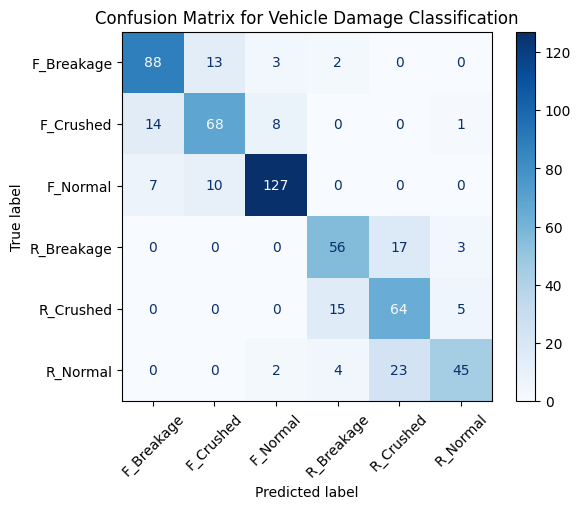

In [61]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
class_names = dataset.classes
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

### Save the model

In [62]:
torch.save(model.state_dict(), 'car_damage_pred_model.pth')